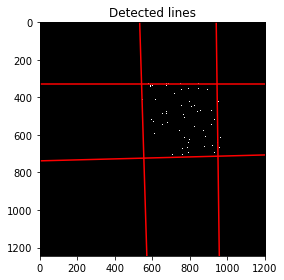

In [58]:
import matplotlib.pyplot as plt
import scipy
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy import stats
from scipy import odr
from scipy.odr import *
from scipy.stats import chisquare
import ast
import cv2
import os
from scipy import signal
import time
from matplotlib import cm
from PIL import Image
import numpy as np
import HoughTransform as HT
from matplotlib.ticker import AutoLocator,AutoMinorLocator

params = {'legend.fontsize': '22',
          'figure.figsize': (10, 8),
         'axes.labelsize': '22',
         'axes.titlesize':'22',
         'xtick.labelsize':'22',
         'ytick.labelsize':'22'}

def getImageDescription(im): return ast.literal_eval(im.tag[270][0])
def getClockScalingFactor(): return (28/1000)/(1750000) 
def get_tiff_integration_time(im): return float(getImageDescription(im)["integration time"])*getClockScalingFactor()


#Going to use this to get rid of dodgy files with 0 integration time
#Courtesy of sam


def get_file_names(folder): #function returns ordered list of numbers of files in folder
    _, _, files = next(os.walk(folder))
    file_names = []
    #dark = []
    for file in files:
        try: 
            #file.replace(date,'')
            #file.replace(file_info,'')
            #file.replace(filetype,'')
            file_names.append(folder+'/'+file)
        except: continue
    return file_names
    

def get_data_loc(folder): #function returns ordered list of numbers of files in folder
    _, folders,_ = next(os.walk(folder))
    fold,dark_fold,IsItOn,Myst = [],[],[],[]
    for subfolder in folders:
        if subfolder.count('dark')==1:
            dark_fold.append(get_file_names(folder+subfolder))
        elif subfolder.count('IsItOn')==1:
            IsItOn.append(get_file_names(folder+subfolder))
        elif subfolder.count('mystery')==1:
            Myst.append(get_file_names(folder+subfolder))
        elif subfolder.count('/.DS_Store')==1:
             continue
        else:
            fold.append(get_file_names(folder+subfolder))
        #fold = sort_folders(fold)
    return fold, dark_fold, IsItOn, Myst


def image_ret(file): return Image.open(file)


def get_images(group): return np.array([np.asarray(image_ret(image)) for image in group])


def sum_images(images): return images.sum(axis=0)


def avg_bunch(group): 
    for image in group:
        if get_tiff_integration_time(image_ret(image)) ==0: 
            group.remove(image)
        else: continue
    stripped_images = get_images(group)
    #average of group of images
    #returns single value for bunch
    return stripped_images.mean(axis=0)


def dark_remov(group,dark_img): 
    for image in group:
        if get_tiff_integration_time(image_ret(image)) ==0: 
            group.remove(image)
        else: continue
    stripped_images = get_images(group)
    stripped_images = np.array([im - dark_img for im in stripped_images])
    #average of group of images
    #returns single value for bunch
    return stripped_images
#np.array([image_ret(i) for i in bckr_count]).mean(axis=0)
   
    
def avg_img(images,img_mean=np.array([])): 
    for image in images:
        if get_tiff_integration_time(image_ret(image)) !=0: 
            np.append(img_mean,np.mean(np.asarray(image_ret(image))))
        else: continue
    #average of each individual image in a bunch
    #returns value for each indivdual image as a list for all the images
    return img_mean


def pixel_val(warped): #takes warped image and 
    in_avg, in_std= np.mean(warped),np.std(warped)/np.sqrt(len(warped))
    return ([in_avg,in_std])

def dose(Ic,w=34.37,t=28*10**(-3),p=1.20479,V=4.90874*10**(-6),unit=1*10**(-12)):
    return (Ic*unit)*w*t/(p*V)

def current_to_dose(currents): return [dose(current) for current in currents]

def get_numbers(data_set,file_info='pA_2x2cm_col',path='LASSENA_Calib/',date='100220',filetype='.tiff'):
    nominal_currents = [0]  
    for data in data_set:
        for file in data:
            file = file.replace(date,'')
            file = file.replace(file_info,'')
            file = file.replace(filetype,'')
            file = file.replace(path,'')
            file = file.replace(file[file.find('/'):],'')
            file = int(file)
            if nominal_currents[-1] != file: nominal_currents.append(file)
    nominal_currents.pop(0)
    nominal_doses = current_to_dose(nominal_currents)
    return nominal_doses


def get_pv(dataset,ROI_pts,dark_img):
    avg_frames_dark_sub = [dark_remov(group,dark_img).mean(axis=0) for group in dataset]
    avg_frame_pv_in_roi = [pixel_val(HT.four_point_transform(image,ROI_pts))[0] for image in avg_frames_dark_sub]
    std_dev_frame_pv = [pixel_val(HT.four_point_transform(image,ROI_pts))[1] for image in avg_frames_dark_sub]
    return avg_frame_pv_in_roi,std_dev_frame_pv


def sort_order(list_for_order,unordered_list): #takes list to get ordered from order of other list
    now_ordered_list = [x for _,x in sorted(zip(list_for_order,unordered_list))]
    ordered_list_for_order = sorted(list_for_order)
    return now_ordered_list,ordered_list_for_order

def read_csv_files_in_folder(folder):
    folder_name = os.listdir(folder)
    for col, filenum in enumerate(folder_name): #puts data in 3d stepping through file
        try:
            file_path = (folder + os.sep + filenum)
            a = np.genfromtxt(file_path, dtype = int,delimiter=',', skip_header=1)#finds the commas and skips title row
            if col == 0: data = np.empty([a.shape[0],a.shape[1], len(folder_name)])
            data[:,:, col] = a
        except: continue
    columns = [*zip(*data[:,0])][0],[*zip(*data[:,1])][0],[*zip(*data[:,3])][0],[*zip(*data[:,4])][0]
    doses = [current_to_dose(column) for column in columns]
    return doses

def poly(param,x): return param[0]*x+param[1]


def try_different_fits(x,y,s_x,s_y):
    param_err0_vals = []
    param_err1_vals = []
    file_lim = []
    for j in range(len(x)-3):
        j = j+3
        linear = Model(poly)
        data = RealData(x[:j], y[:j], sx=s_x[:j], sy=s_y[:j])
        odr = ODR(data, linear, beta0=[0.0, 0.0])
        out = odr.run()
        sd_error = out.sd_beta
        param_err0_vals.append(sd_error[0])
        param_err1_vals.append(sd_error[1])
        file_lim.append(x[j])
    best_num = np.argmin(param_err0_vals)
    linear = Model(poly)
    data = RealData(x[:best_num], y[:best_num], sx=s_x[:best_num], sy=s_y[:best_num])
    odr = ODR(data, linear, beta0=[0.0, 1.0])
    out = odr.run()
    popt = out.beta
    sd_error = out.sd_beta
    return  param_err0_vals, param_err1_vals, file_lim, popt, sd_error


def save_fig(file_name):
    plt.savefig(file_name, dpi=300, quality=95, facecolor='w', edgecolor='w',
    orientation='portrait', papertype=None, format=None,
    transparent=False, bbox_inches=None, pad_inches=0.1,metadata=None)

def current(dose,w=34.37,t=28*10**(-3),p=1.20479,V=4.90874*10**(-6),unit=1*10**(-12)):
    return dose*p*V/(w*t*unit)

def get_dose_with_stp_pwr(S_now,S_new,D_now):
    return (S_now/S_new)*D_now

def plot_saturation(nominal_doses,mid_dose,err_mid_dose,warped_files,std_dev,param_err0_vals, param_err1_vals,file_max,best_param,best_err,ptiv_error,ntiv_error):
    new_dose = [get_dose_with_stp_pwr(17.48,14.28,dose) for dose in mid_dose]
    new_dose_err = [get_dose_with_stp_pwr(17.48,14.28,dose) for dose in err_mid_dose]
    _, _,_,new_best_param,_ = try_different_fits(new_dose,warped_files,new_dose_err,std_dev) 
    new_fit = [poly(new_best_param,i) for i in new_dose]
    _,ax1 = plt.subplots(figsize =(10,8))
    ax1.set_title('Dark subtracted Pixel Value vs Dose',size='15')
    ax1.set_xlabel('Dose /Gy')
    ax1.set_ylabel('Dark subtracted Pixel Value')
    ax1.errorbar(x=nominal_doses,y=warped_files,yerr=std_dev,xerr = np.array([ntiv_error,ptiv_error]),ls='None',capsize=2,barsabove=True)
    ax1.plot(nominal_doses,warped_files,'r.',label='Nominal values')
    ax1.plot(mid_dose,warped_files,'g.',label='Mid-points')
    ax1.plot(mid_dose,[poly(best_param,i) for i in mid_dose],label=r'{:.3f}$x${:.3f}'.format(best_param[0],best_param[1]))
    ax1.plot(new_dose,new_fit,'b',label='36MeV Prediction: {:.3f}$x${:.3f}'.format(new_best_param[0],new_best_param[1]))
    secax = ax1.secondary_xaxis('top',functions=(current,dose))
    secax.xaxis.set_minor_locator(AutoMinorLocator())
    secax.set_xlabel('Current /pA')
    ax1.legend()
    #save_fig('36MeV_Pixel_Value_Prediction')

    predicted = [poly(best_param,mi) for mi in mid_dose]
    actual = warped_files
    ratio = [float(actual[i]/predicted[i]) for i in range(len(actual))]
    difference =  [float(actual[i]-predicted[i]) for i in range(len(actual))]
    ratio_err= [ratio[i]*np.sqrt((std_dev[i]/actual[i])**2) for i in range(len(actual))]


    error_on_y = [(best_param[0]*(file_max[i])+best_param[1])*np.sqrt((param_err0_vals[i]/best_param[0])**(2) + (param_err1_vals[i]/best_param[1])**(2)) \
                  for i in range(len(file_max))]

    _,ax2 = plt.subplots(figsize=(10,8))
    ax2.plot(file_max,error_on_y,'b.')
    ax2.set_title('Error on Dark subtracted PV vs Dose with best fit from linear fit',size='15')
    ax2.set_xlabel('Max Dose used in linear fit / Gy')
    ax2.set_ylabel('Error on Dark substracted PV')
    secax2 = ax2.secondary_xaxis('top',functions=(current,dose))
    secax2.xaxis.set_minor_locator(AutoMinorLocator())
    secax2.set_xlabel('Current /pA')
    save_fig('error_on_y')
    ax2.legend()


    _,ax3 = plt.subplots(figsize=(10,8))
    ax3.plot(mid_dose,ratio,'g.',label='Ratio values')
    ax3.errorbar(x=mid_dose,y=ratio,xerr=err_mid_dose,yerr=ratio_err,ls='None',capsize=2,barsabove=True)
    ax3.axhline(1.05,color='r',label='5% more than 1')
    ax3.axhline(0.95,color='g',label='5% less than 1')
    ax3.set_title('Ratio of actual to best fit netPV value vs dose',size='15')
    ax3.set_ylabel('Ratio of actual to best fit netPV')
    ax3.set_xlabel('Dose / Gy')
    secax3 = ax3.secondary_xaxis('top',functions=(current,dose))
    secax3.xaxis.set_minor_locator(AutoMinorLocator())
    secax3.set_xlabel('Current /pA')
    ax3.legend()

    plt.show()
    
def get_image_dose(image,dark_img,best_param): #feed it an image
    image = image - dark_img #Dark subtracted
    dose = (image-best_param[1])/best_param[0]
    #plt.imshow(dose)
    #plt.colorbar(label='Dose /Gy')
    return dose #Inversed linear function

def cumulative_dose(files,dark_img,best_param):
    images = get_images(files)
    doses = np.array([get_image_dose(image,dark_img,best_param) for image in images])
    cum_dose = doses.sum(axis=0)
    plt.imshow(cum_dose)
    plt.title('10500pA cumulative dose irradiation')
    plt.colorbar(label='Dose /Gy')
    plt.show()
    #print(len(files))
    #save_fig('10500pA_cum_dose')
    return cum_dose

def main():
    data, dark, OnCheck, Myst = get_data_loc(folder='LASSENA_Calib/')
    dark_start = avg_bunch(dark[1]) #used dark recorded at start
    img_for_roi = dark_start-avg_bunch(data[18])
    ROI_pts = HT.cross_points(img_for_roi, HT.hough_grid(img_for_roi))
    nominal_doses = get_numbers(data)
    warped_files,std_dev = get_pv(data,ROI_pts,dark_start)
    std_dev,_ = sort_order(nominal_doses,std_dev)
    warped_files,nominal_doses = sort_order(nominal_doses,warped_files)
    #myst_warped,myst_std_dev = get_pv(Myst,ROI_pts,dark_start)
    ptiv_error,ntiv_error,mid_dose,err_mid_dose = read_csv_files_in_folder(r'Current Error')
    param_err0_vals, param_err1_vals, file_max,best_param,best_err = try_different_fits(mid_dose,warped_files,err_mid_dose,std_dev) 
    #plot_saturation(nominal_doses,mid_dose,err_mid_dose,warped_files,std_dev,param_err0_vals, param_err1_vals,file_max,best_param,best_err,ptiv_error,ntiv_error)
    return data, best_param, dark_start
    
if __name__=="__main__":
    data, best_params, dark_image = main()

In [61]:
print(data[18])
'''
dark_mid = avg_bunch(dark[0])
dark_end = avg_bunch(dark[2])
plt.imshow(avg_bunch(dark[0])-avg_bunch(dark[1]),cm.gray)
plt.title('Avg dark PV at mid (3000pA) - Avg dark PV at start (0pA)')
plt.show()
plt.imshow(avg_bunch(dark[2])-avg_bunch(dark[0]),cm.gray)
plt.title('Avg dark PV at end (10500pA) - Avg dark PV at mid (3000pA)')
plt.show()
plt.imshow(avg_bunch(dark[2])-avg_bunch(dark[1]),cm.gray)
plt.title('Avg dark PV at end (10500pA) - Avg dark PV at start (0pA)')
plt.show()
print('Avg dark 0pA PV {}'.format(np.mean(avg_bunch(dark[1]))))
print('Avg dark 3000pA PV {}'.format(np.mean(avg_bunch(dark[0]))))
print('Avg dark 10500pA PV {}'.format(np.mean(avg_bunch(dark[2]))))
'''

['LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_56.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_17.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_40.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_9.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_83.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_95.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_37.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_5.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_60.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_76.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_99.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_21.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_20.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_77.tiff', 'LASSENA_Calib/6000pA_2x2cm_col/100220_6000pA_2x2cm_col_98.tiff', 'LASSENA_Ca

"\ndark_mid = avg_bunch(dark[0])\ndark_end = avg_bunch(dark[2])\nplt.imshow(avg_bunch(dark[0])-avg_bunch(dark[1]),cm.gray)\nplt.title('Avg dark PV at mid (3000pA) - Avg dark PV at start (0pA)')\nplt.show()\nplt.imshow(avg_bunch(dark[2])-avg_bunch(dark[0]),cm.gray)\nplt.title('Avg dark PV at end (10500pA) - Avg dark PV at mid (3000pA)')\nplt.show()\nplt.imshow(avg_bunch(dark[2])-avg_bunch(dark[1]),cm.gray)\nplt.title('Avg dark PV at end (10500pA) - Avg dark PV at start (0pA)')\nplt.show()\nprint('Avg dark 0pA PV {}'.format(np.mean(avg_bunch(dark[1]))))\nprint('Avg dark 3000pA PV {}'.format(np.mean(avg_bunch(dark[0]))))\nprint('Avg dark 10500pA PV {}'.format(np.mean(avg_bunch(dark[2]))))\n"